In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
import xscale
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [9]:
client

<Client: 'tcp://10.148.1.101:52070' processes=5 threads=140, memory=600.00 GB>

_________
# 1. Read dataset


In [10]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'

# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr')
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr')

# data merge
ds = xr.merge([ds_KPP,ds_TAUX,ds_TAUY,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 367)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(367,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-16 ... 2012-11-15
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i

In [11]:
# coriolis term
lat = ds['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

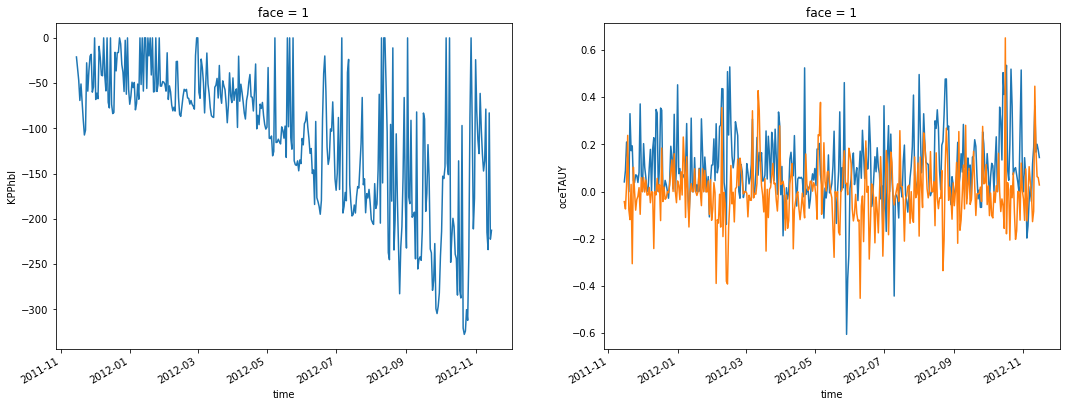

In [8]:
fig = plt.figure(figsize=(18,6))

plt.subplot(121)
(-1*ds['KPPhbl']).isel(face=1,i=slice(90,100), j=slice(90,100)).mean(dim=['i','j']).plot()

plt.subplot(122)
(ds['oceTAUX']).isel(face=1,i_g=slice(90,100), j=slice(90,100)).mean(dim=['i_g','j']).plot()
(ds['oceTAUY']).isel(face=1,i=slice(90,100), j_g=slice(90,100)).mean(dim=['i','j_g']).plot()

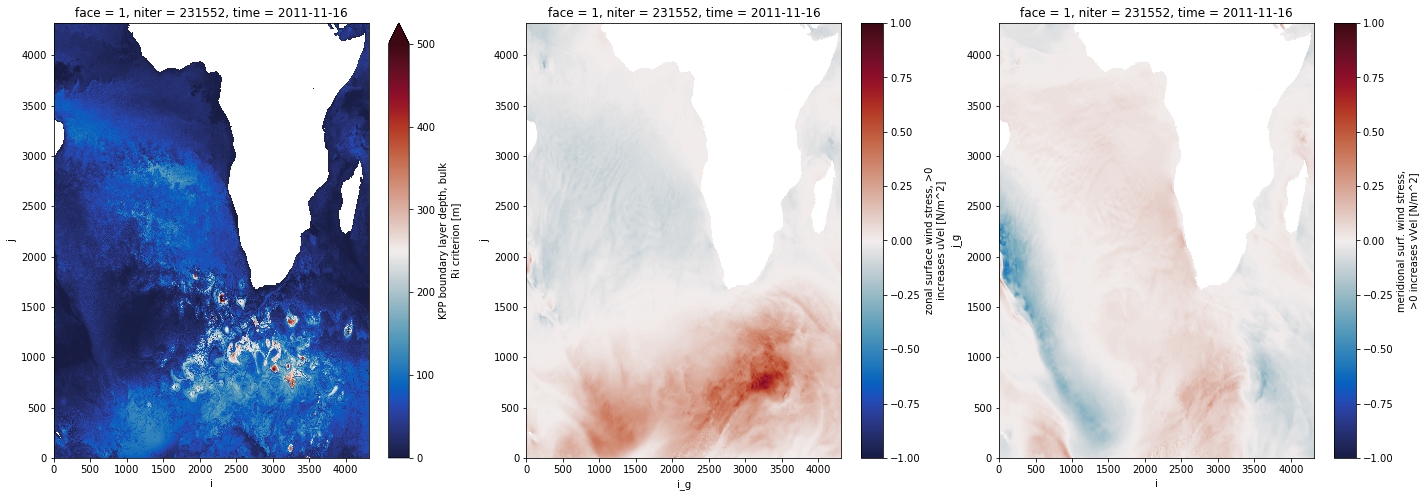

In [14]:
fig, ax = plt.subplots(figsize=(24,8))
ax = plt.subplot(131)
ds['KPPhbl'].isel(face=1,time=1).plot(x='i', y='j', cmap = cm.balance, vmin=0,vmax=500)

ax = plt.subplot(132)
ds['oceTAUX'].isel(face=1,time=1).plot(x='i_g', y='j', cmap = cm.balance, vmin=-1, vmax=1)

ax = plt.subplot(133)
ds['oceTAUY'].isel(face=1,time=1).plot(x='i', y='j_g', cmap = cm.balance, vmin=-1, vmax=1)

In [11]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

____________
# Rotation

In [6]:
grid = xgcm.Grid(ds, coords={'X':{'center':'i', 'left':'i_g'},
                              'Y':{'center':'j', 'left':'j_g'}}, periodic=['X', 'Y'])

store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

<xgcm.Grid>
X Axis (periodic):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic):
  * center   j --> left
  * left     j_g --> center

In [23]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUX_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        oceTAUX_ij = grid.interp(ds['oceTAUX'].isel(face=face),'X')
        oceTAUY_ij = grid.interp(ds['oceTAUY'].isel(face=face),'Y')
        oceTAUX =  oceTAUX_ij*ds.CS.isel(face=face) - oceTAUY_ij*ds.SN.isel(face=face)
        chunks = {'time':1, 'i': 4320, 'j': 4320}
        oceTAUX = oceTAUX.chunk(chunks)
        
        # store
        oceTAUX = np.real(oceTAUX).rename('oceTAUX')
        oceTAUX = oceTAUX.to_dataset()
        
        for c in oceTAUX.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUX.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 14.7 s, sys: 1.02 s, total: 15.7 s
Wall time: 1min 15s
--- face 0 done
CPU times: user 16.2 s, sys: 1.25 s, total: 17.5 s
Wall time: 1min 39s
--- face 1 done
CPU times: user 17.6 s, sys: 1.35 s, total: 19 s
Wall time: 1min 48s
--- face 2 done
CPU times: user 14.5 s, sys: 1.05 s, total: 15.6 s
Wall time: 1min 12s
--- face 3 done
CPU times: user 16.2 s, sys: 1.21 s, total: 17.4 s
Wall time: 1min 33s
--- face 4 done
CPU times: user 13.9 s, sys: 992 ms, total: 14.9 s
Wall time: 1min 11s
--- face 5 done
CPU times: user 15.1 s, sys: 1.25 s, total: 16.3 s
Wall time: 1min 22s
--- face 6 done
CPU times: user 14.8 s, sys: 1.06 s, total: 15.9 s
Wall time: 1min 24s
--- face 7 done
CPU times: user 17 s, sys: 1.4 s, total: 18.4 s
Wall time: 1min 41s
--- face 8 done
CPU times: user 14.4 s, sys: 1.1 s, total: 15.4 s
Wall time: 1min 12s
--- face 9 done
CPU times: user 15.3 s, sys: 1.08 s, total: 16.4 s
Wall time: 1min 20s
--- face 10 done
CPU times: user 17.3 s, sys: 1.18 s, total: 18.4

In [24]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUY_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        oceTAUX_ij = grid.interp(ds['oceTAUX'].isel(face=face),'X')
        oceTAUY_ij = grid.interp(ds['oceTAUY'].isel(face=face),'Y')
        oceTAUY =  oceTAUX_ij*ds.SN.isel(face=face) + oceTAUY_ij*ds.CS.isel(face=face)

        chunks = {'time':1, 'i': 4320, 'j': 4320}
        oceTAUY = oceTAUY.chunk(chunks)
        
        # store
        oceTAUY = np.real(oceTAUY).rename('oceTAUY')
        oceTAUY = oceTAUY.to_dataset()
        
        for c in oceTAUY.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass     
        
        %time oceTAUY.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 15.7 s, sys: 1.1 s, total: 16.8 s
Wall time: 1min 23s
--- face 0 done
CPU times: user 14.6 s, sys: 980 ms, total: 15.5 s
Wall time: 1min 14s
--- face 1 done
CPU times: user 14.1 s, sys: 992 ms, total: 15.1 s
Wall time: 1min 7s
--- face 2 done
CPU times: user 14.6 s, sys: 1.02 s, total: 15.7 s
Wall time: 1min 12s
--- face 3 done
CPU times: user 15.4 s, sys: 1.01 s, total: 16.4 s
Wall time: 1min 18s
--- face 4 done
CPU times: user 13.6 s, sys: 1.1 s, total: 14.7 s
Wall time: 1min 2s
--- face 5 done
CPU times: user 18.3 s, sys: 1.17 s, total: 19.5 s
Wall time: 1min 51s
--- face 6 done
CPU times: user 17.9 s, sys: 1.2 s, total: 19.1 s
Wall time: 1min 40s
--- face 7 done
CPU times: user 15.9 s, sys: 1.11 s, total: 17 s
Wall time: 1min 22s
--- face 8 done
CPU times: user 15 s, sys: 964 ms, total: 16 s
Wall time: 1min 14s
--- face 9 done
CPU times: user 15.4 s, sys: 1.05 s, total: 16.4 s
Wall time: 1min 17s
--- face 10 done
CPU times: user 15.4 s, sys: 1.15 s, total: 16.5 s
Wa

# RMS

In [9]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUX_rms_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        oceTAUX_ij = grid.interp(ds['oceTAUX'].isel(face=face),'X')
        oceTAUY_ij = grid.interp(ds['oceTAUY'].isel(face=face),'Y')
        oceTAUX =  oceTAUX_ij*ds.CS.isel(face=face) - oceTAUY_ij*ds.SN.isel(face=face)
        oceTAUX_rms = (oceTAUX**2).mean(['time'])
     
        chunks = {'i': 4320, 'j': 4320}
        oceTAUX_rms = oceTAUX_rms.chunk(chunks)
        
        # store
        oceTAUX_rms = np.real(oceTAUX_rms).rename('oceTAUX_rms')
        oceTAUX_rms = oceTAUX_rms.to_dataset()
        
        for c in oceTAUX_rms.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUX_rms.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 20.5 s, sys: 1.68 s, total: 22.2 s
Wall time: 2min 45s
--- face 0 done
CPU times: user 19.1 s, sys: 1.6 s, total: 20.7 s
Wall time: 2min 35s
--- face 1 done
CPU times: user 19.3 s, sys: 1.68 s, total: 21 s
Wall time: 2min 44s
--- face 2 done
CPU times: user 20.3 s, sys: 1.66 s, total: 21.9 s
Wall time: 2min 49s
--- face 3 done
CPU times: user 16.7 s, sys: 1.38 s, total: 18.1 s
Wall time: 1min 59s
--- face 4 done
CPU times: user 20 s, sys: 1.58 s, total: 21.6 s
Wall time: 2min 50s
--- face 5 done
CPU times: user 19.3 s, sys: 1.62 s, total: 20.9 s
Wall time: 2min 41s
--- face 6 done
CPU times: user 17.7 s, sys: 1.38 s, total: 19 s
Wall time: 2min 14s
--- face 7 done
CPU times: user 18.2 s, sys: 1.44 s, total: 19.7 s
Wall time: 2min 13s
--- face 8 done
CPU times: user 18.1 s, sys: 1.52 s, total: 19.7 s
Wall time: 2min 15s
--- face 9 done
CPU times: user 19.3 s, sys: 1.69 s, total: 21 s
Wall time: 2min 51s
--- face 10 done
CPU times: user 19.2 s, sys: 1.51 s, total: 20.8 s


In [15]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUY_rms_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        oceTAUX_ij = grid.interp(ds['oceTAUX'].isel(face=face),'X')
        oceTAUY_ij = grid.interp(ds['oceTAUY'].isel(face=face),'Y')
        oceTAUY =  oceTAUX_ij*ds.SN.isel(face=face) + oceTAUY_ij*ds.CS.isel(face=face)
        oceTAUY_rms = (oceTAUY**2).mean(['time'])
     
        chunks = {'i': 4320, 'j': 4320}
        oceTAUY_rms = oceTAUY_rms.chunk(chunks)
        
        # store
        oceTAUY_rms = np.real(oceTAUY_rms).rename('oceTAUY_rms')
        oceTAUY_rms = oceTAUY_rms.to_dataset()
        
        for c in oceTAUY_rms.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUY_rms.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 17.6 s, sys: 1.88 s, total: 19.5 s
Wall time: 2min 13s
--- face 0 done
CPU times: user 18.5 s, sys: 1.44 s, total: 19.9 s
Wall time: 2min 16s
--- face 1 done
CPU times: user 17.8 s, sys: 1.32 s, total: 19.1 s
Wall time: 2min 8s
--- face 2 done
CPU times: user 18.9 s, sys: 1.36 s, total: 20.3 s
Wall time: 2min 23s
--- face 3 done
CPU times: user 18.1 s, sys: 1.34 s, total: 19.4 s
Wall time: 1min 57s
--- face 4 done
CPU times: user 18.5 s, sys: 1.27 s, total: 19.8 s
Wall time: 2min 20s
--- face 5 done
CPU times: user 20 s, sys: 1.42 s, total: 21.4 s
Wall time: 2min 28s
--- face 6 done
CPU times: user 19.8 s, sys: 1.37 s, total: 21.2 s
Wall time: 2min 32s
--- face 7 done
CPU times: user 19.7 s, sys: 1.19 s, total: 20.9 s
Wall time: 2min 15s
--- face 8 done
CPU times: user 18.6 s, sys: 1.27 s, total: 19.9 s
Wall time: 2min 16s
--- face 9 done
CPU times: user 18.9 s, sys: 1.38 s, total: 20.3 s
Wall time: 2min 31s
--- face 10 done
CPU times: user 19.5 s, sys: 1.52 s, total: 2

In [ ]:
ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr')

In [18]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'KPPhbl_rms_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:


        KPPhbl_rms = ((ds_KPP.KPPhbl.isel(face=face))**2).mean(['time'])
     
        chunks = {'i': 4320, 'j': 4320}
        KPPhbl_rms = KPPhbl_rms.chunk(chunks)
        
        # store
        KPPhbl_rms = np.real(KPPhbl_rms).rename('KPPhbl_rms')
        KPPhbl_rms = KPPhbl_rms.to_dataset()
        
        for c in KPPhbl_rms.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time KPPhbl_rms.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 2.23 s, sys: 144 ms, total: 2.37 s
Wall time: 42.1 s
--- face 0 done
CPU times: user 3.64 s, sys: 220 ms, total: 3.86 s
Wall time: 1min 34s
--- face 1 done
CPU times: user 2.2 s, sys: 168 ms, total: 2.37 s
Wall time: 42.3 s
--- face 2 done
CPU times: user 2.19 s, sys: 200 ms, total: 2.39 s
Wall time: 41.9 s
--- face 3 done
CPU times: user 2.28 s, sys: 212 ms, total: 2.5 s
Wall time: 44 s
--- face 4 done
CPU times: user 2.59 s, sys: 136 ms, total: 2.72 s
Wall time: 44.5 s
--- face 5 done
CPU times: user 2.23 s, sys: 164 ms, total: 2.39 s
Wall time: 40.4 s
--- face 6 done
CPU times: user 2.2 s, sys: 128 ms, total: 2.33 s
Wall time: 39.2 s
--- face 7 done
CPU times: user 2.24 s, sys: 212 ms, total: 2.45 s
Wall time: 42.2 s
--- face 8 done
CPU times: user 2.49 s, sys: 204 ms, total: 2.7 s
Wall time: 43 s
--- face 9 done
CPU times: user 2.33 s, sys: 132 ms, total: 2.46 s
Wall time: 45.8 s
--- face 10 done
CPU times: user 2.22 s, sys: 152 ms, total: 2.37 s
Wall time: 39.7 s
-

_________
# Read and plot RMS results

In [13]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'TAUX_rms_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUX = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'TAUY_rms_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUY = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'KPPhbl_rms_f%02d.zarr'%(face)) for face in face_all] 
ds_KPPhbl = xr.concat(D, dim='face')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

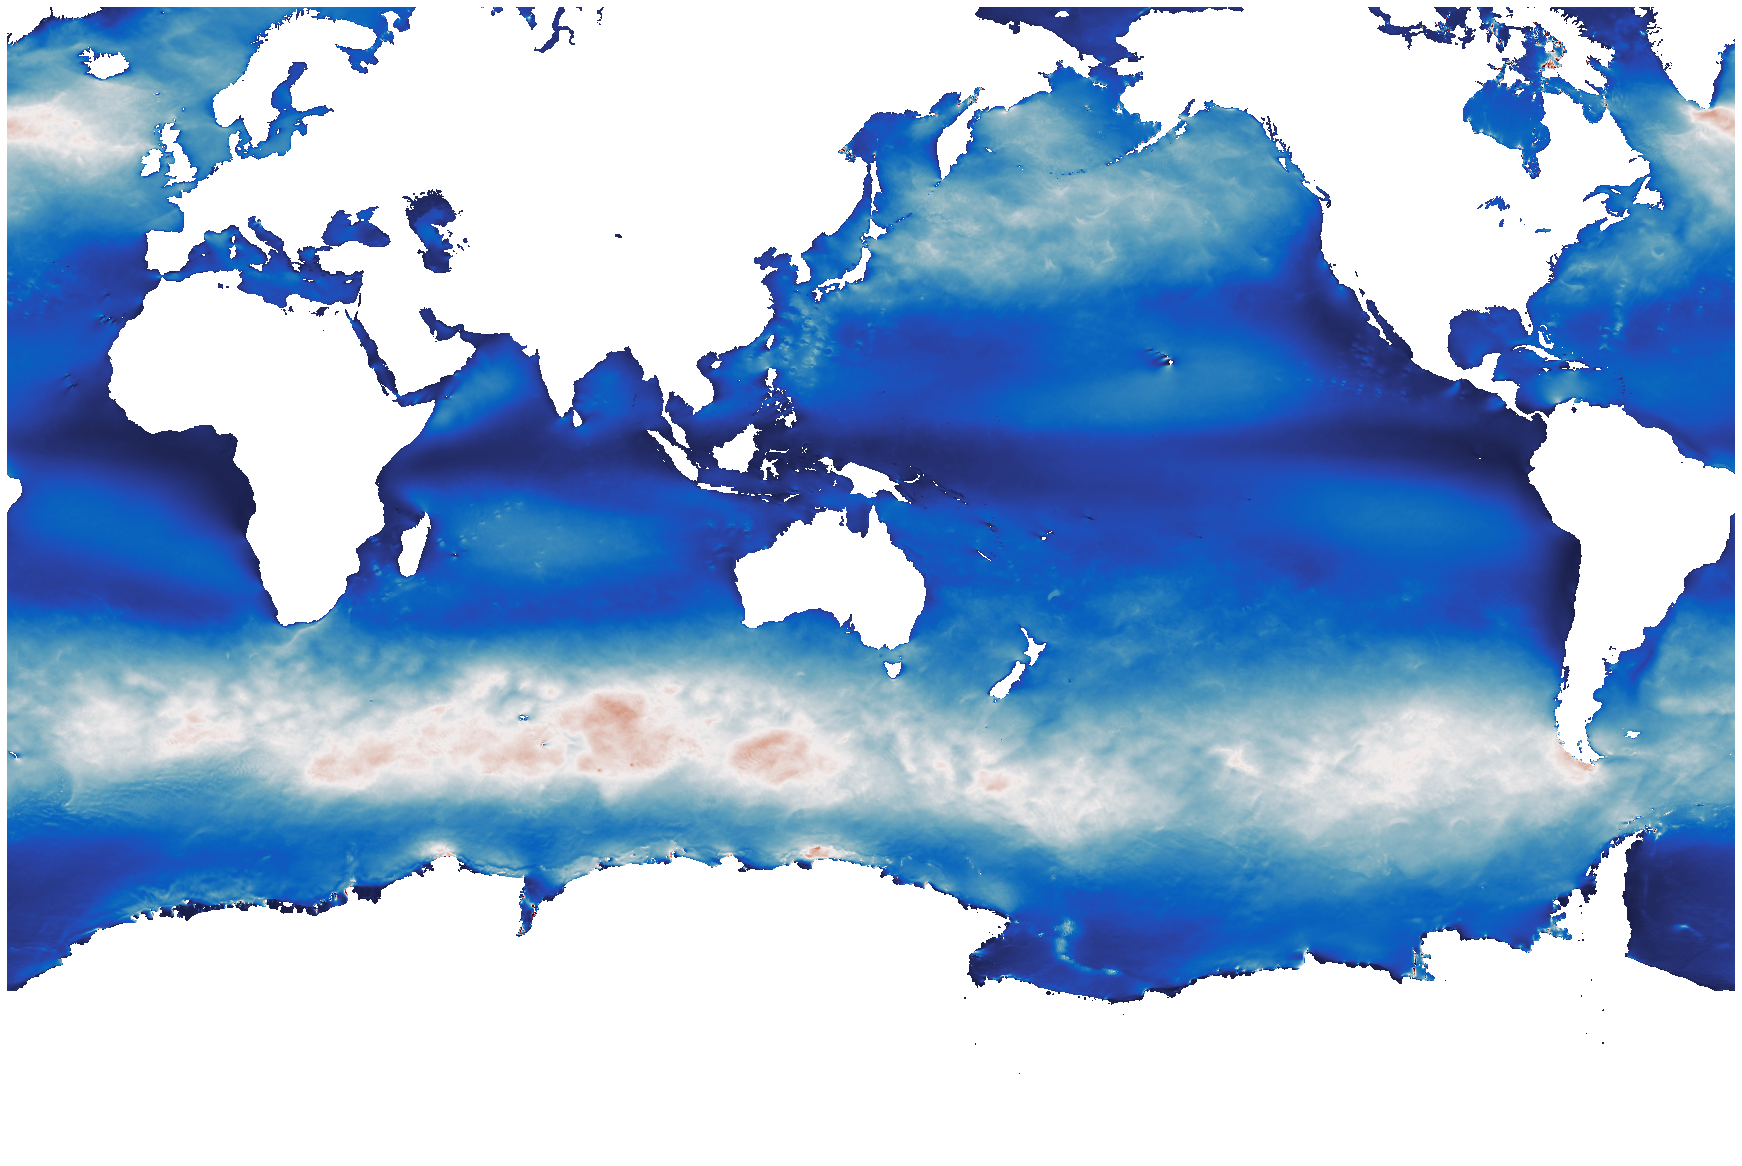

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.148.1.103:51621 remote=tcp://10.148.1.103:40265>


In [40]:
quick_llc_plot(np.sqrt(ds_TAUX.oceTAUX_rms), vmin=0, vmax=0.5, add_colorbar=False, axis_off=True, cmap = cm.balance)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

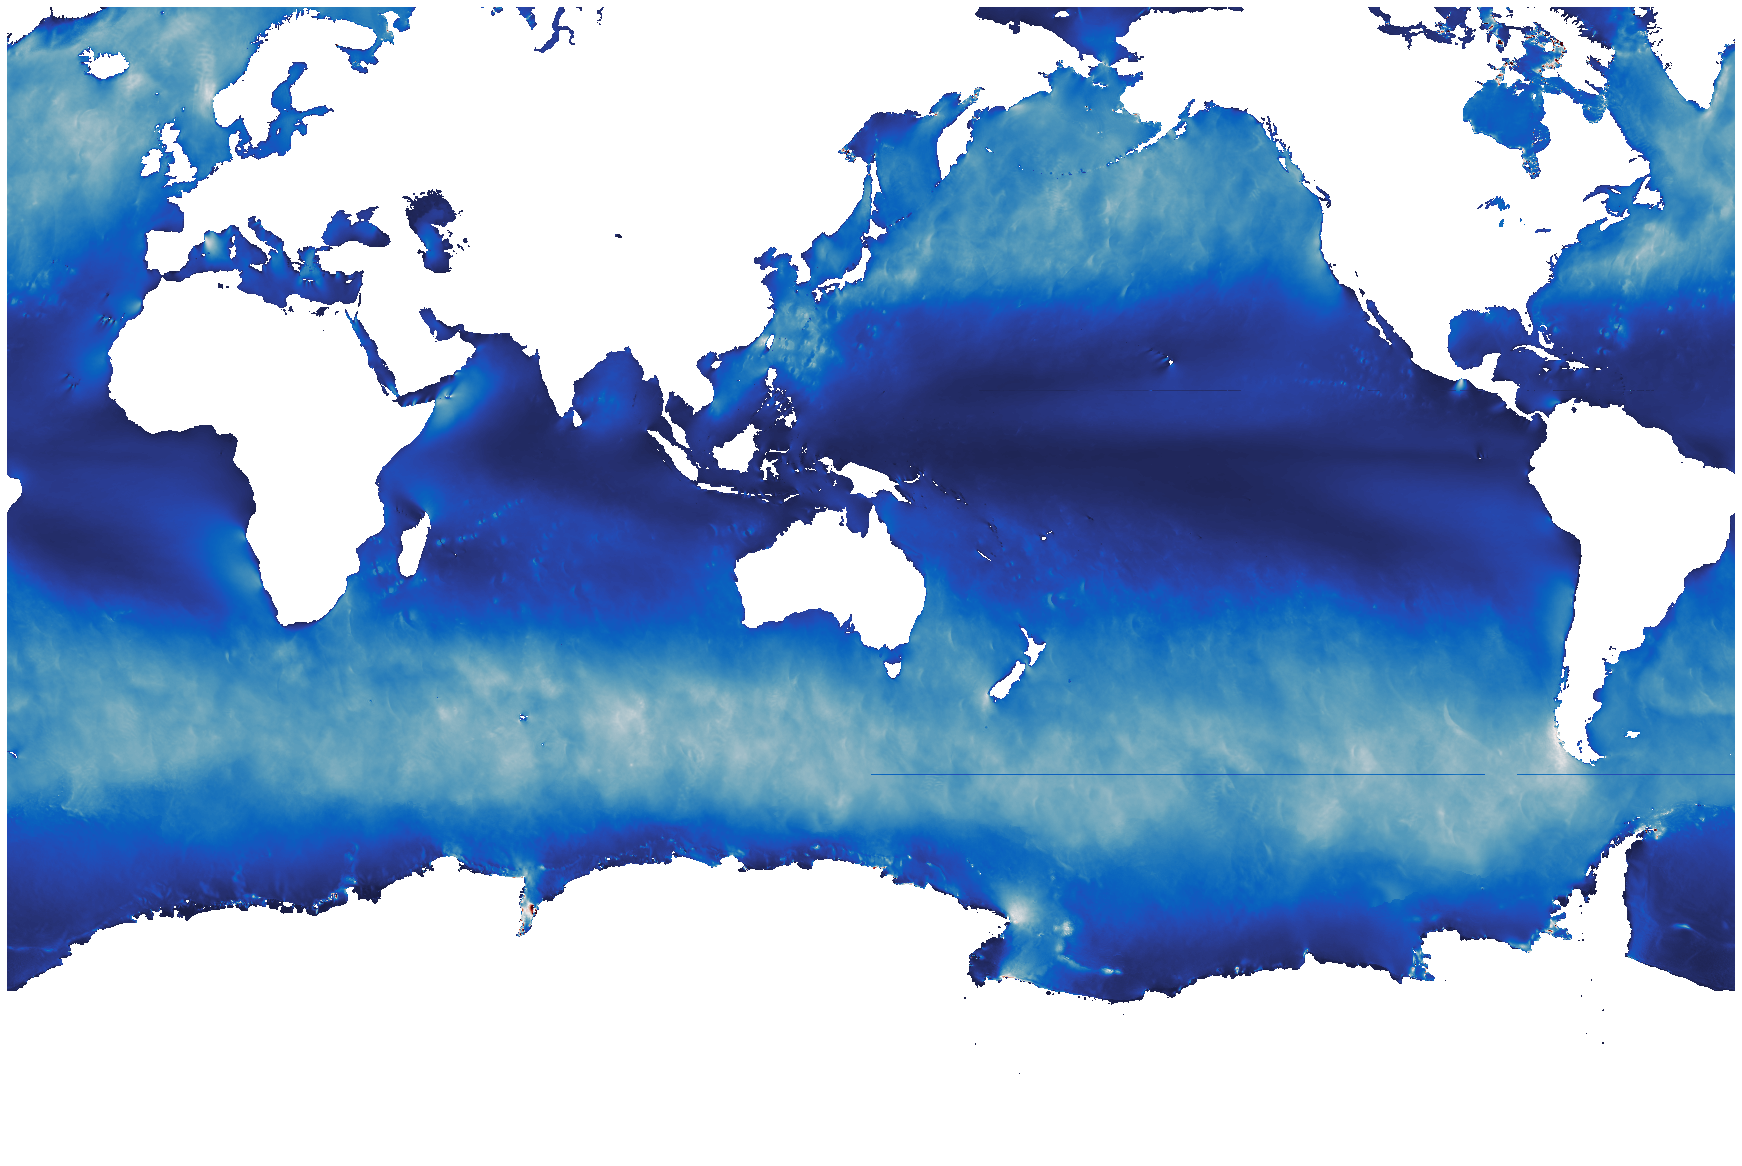

In [41]:
quick_llc_plot(np.sqrt(ds_TAUY.oceTAUY_rms), vmin=0, vmax=0.5, add_colorbar=False, axis_off=True, cmap = cm.balance)

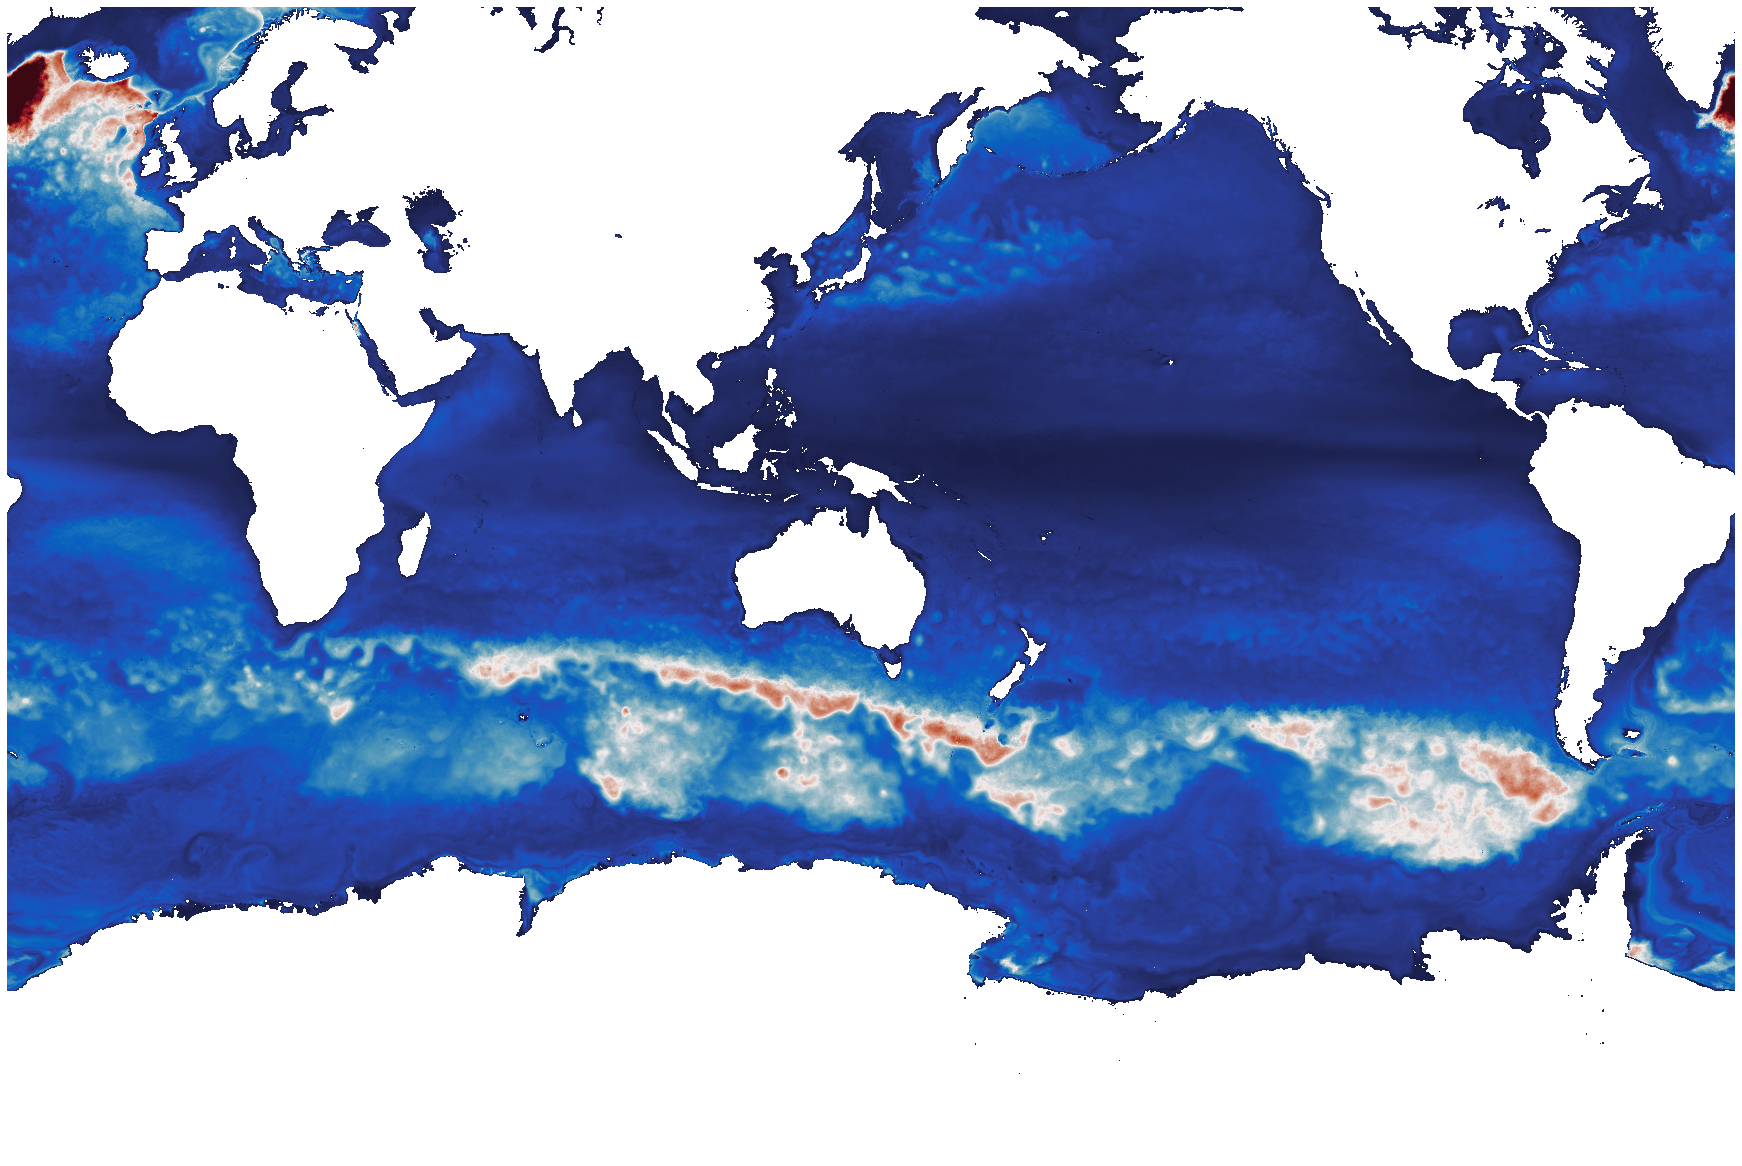

In [37]:
quick_llc_plot(np.sqrt(ds_KPPhbl.KPPhbl_rms), vmin=0, vmax=500, add_colorbar=False, axis_off=True, cmap = cm.balance)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

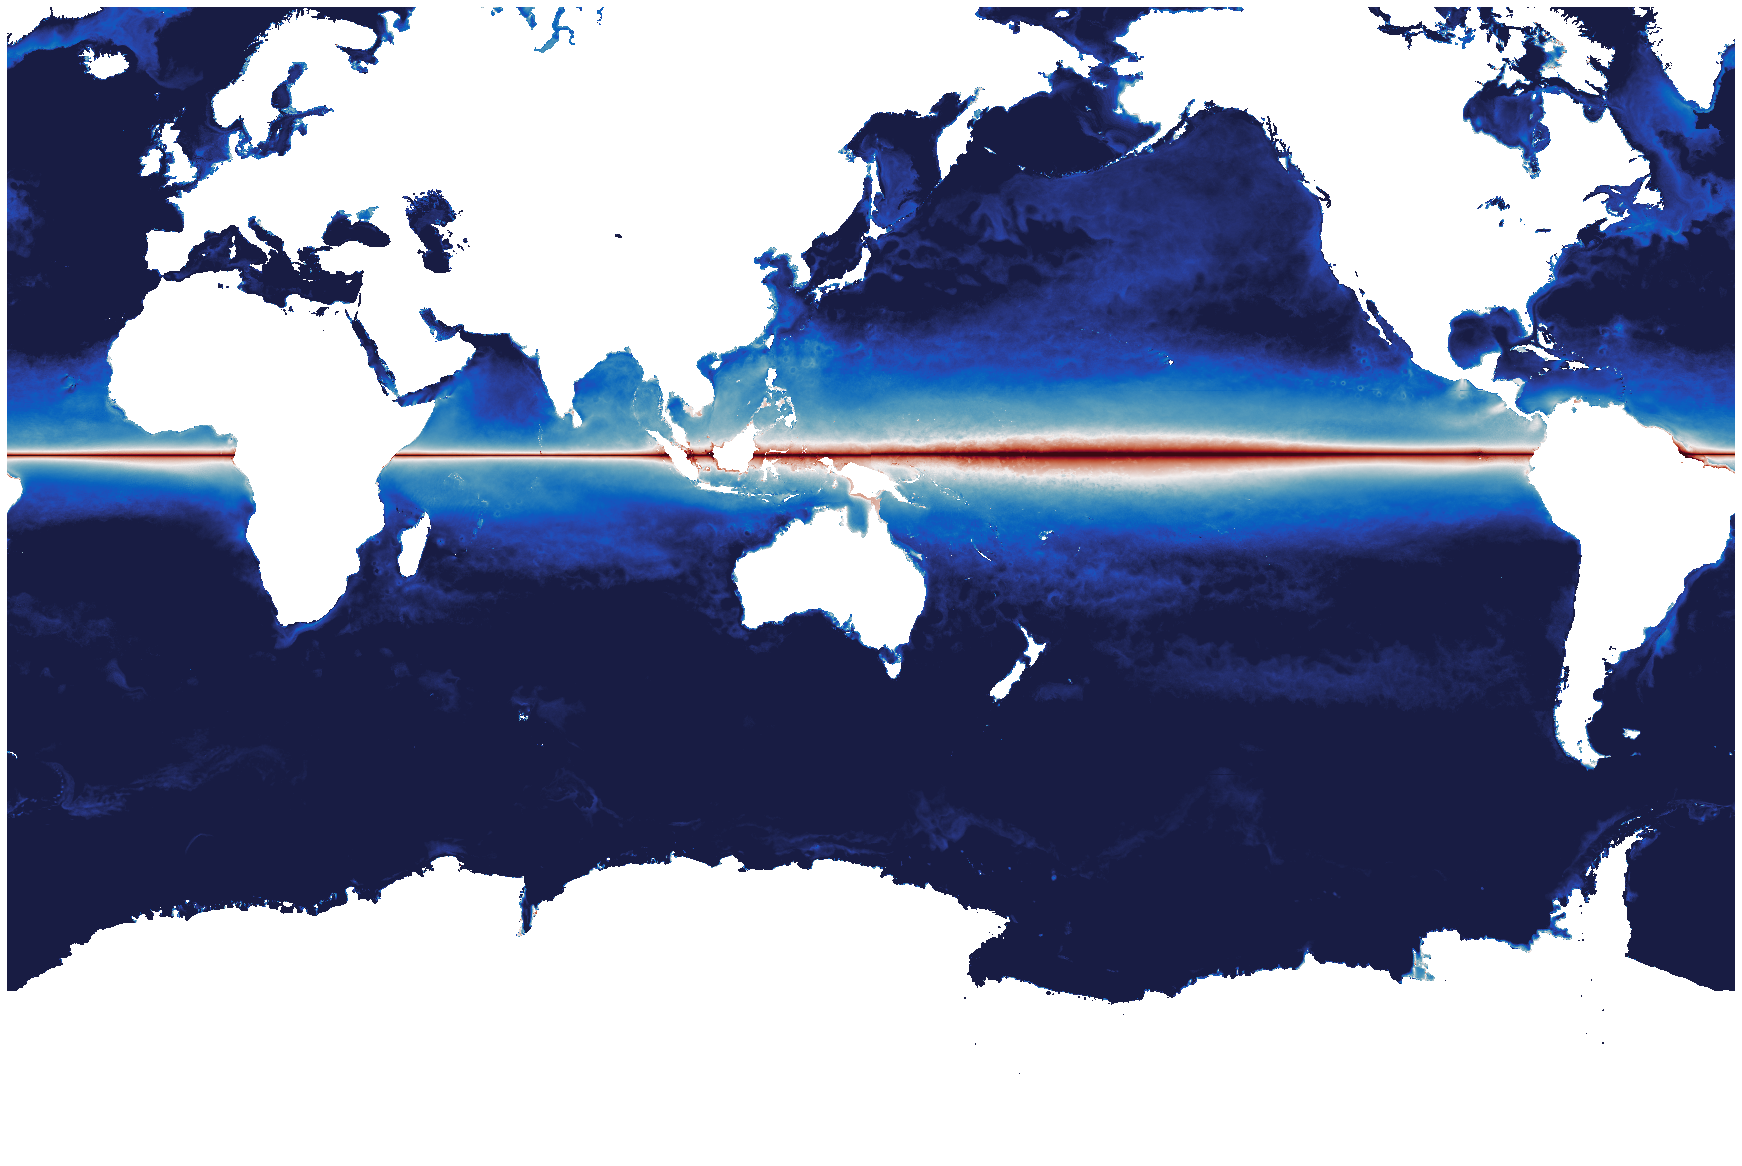

In [17]:
quick_llc_plot( np.log10((ds_TAUX.oceTAUX_rms+ds_TAUY.oceTAUY_rms)/ds_KPPhbl.KPPhbl_rms/1025/1025/(f_ij**2)/86400), vmin=-8, vmax=-3, add_colorbar=False, axis_off=True, cmap = cm.balance)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

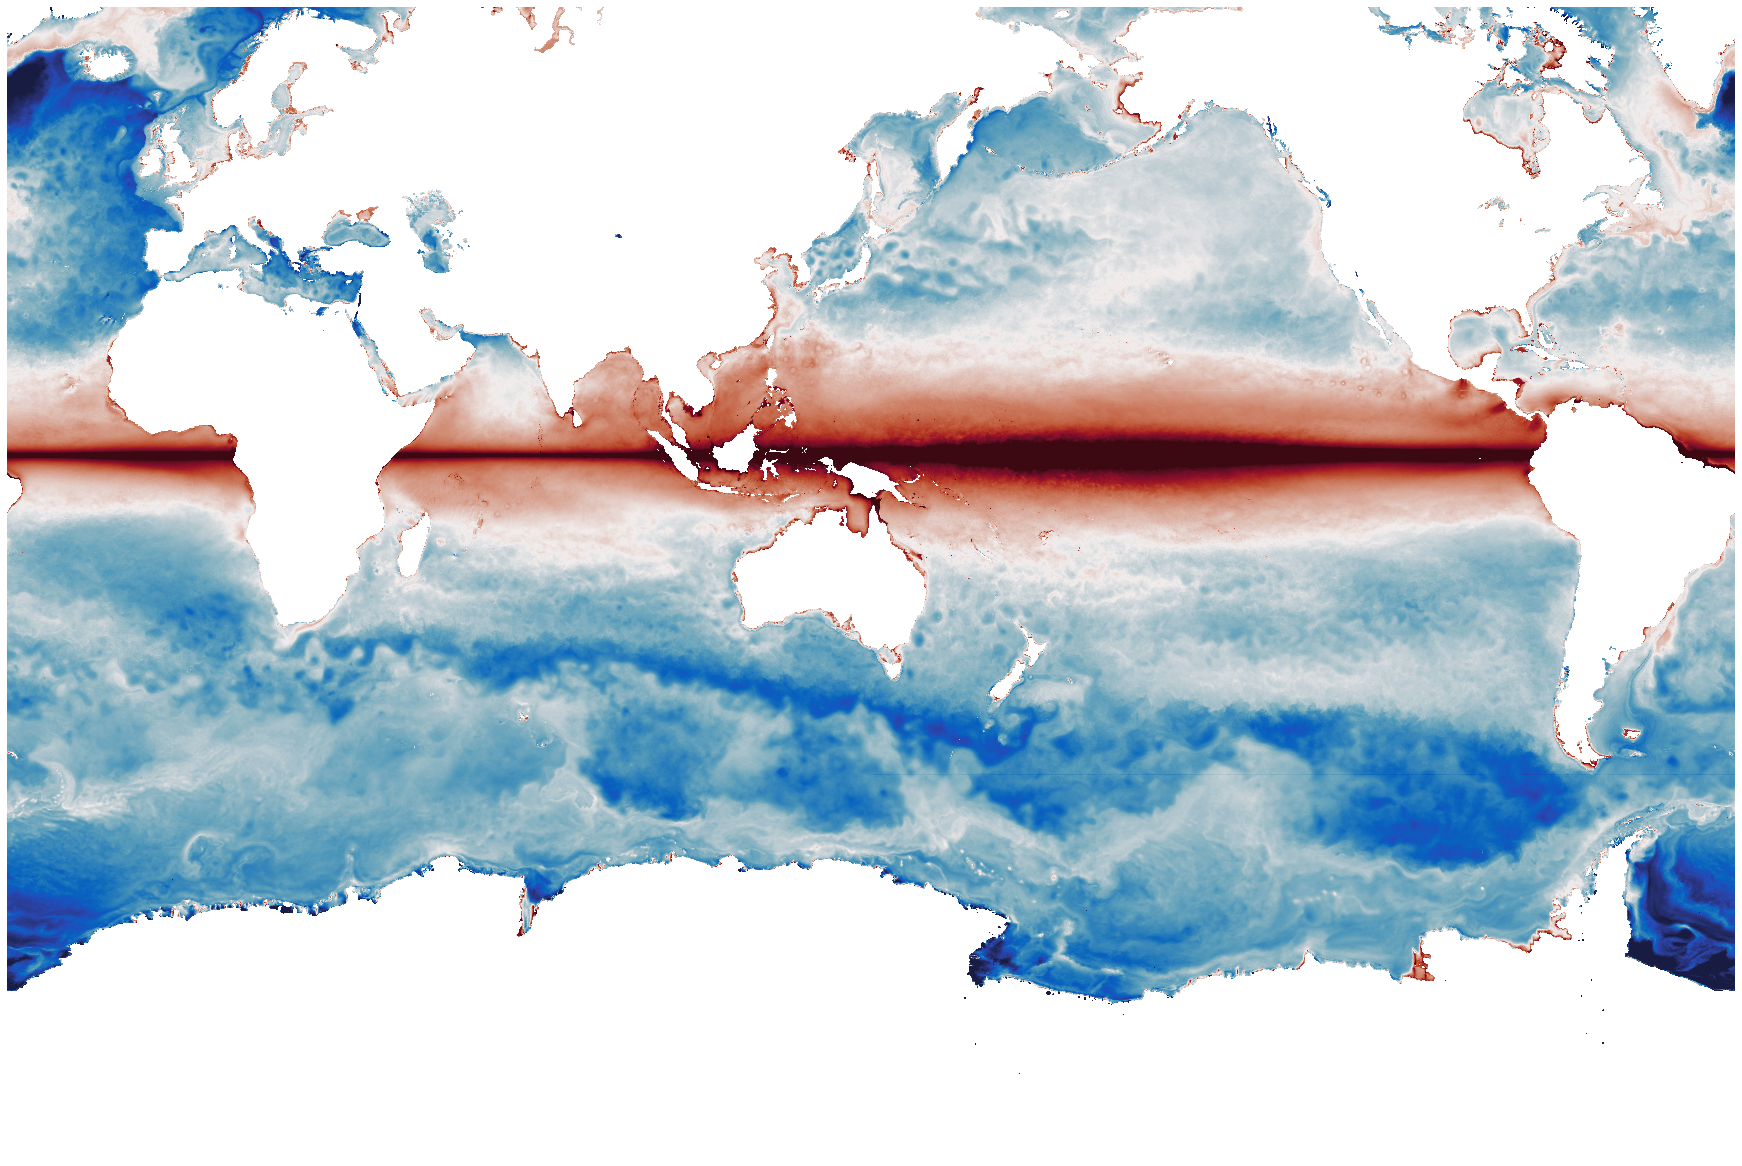

In [18]:
quick_llc_plot( np.log10((ds_TAUX.oceTAUX_rms+ds_TAUY.oceTAUY_rms)/ds_KPPhbl.KPPhbl_rms/1025/1025/(f_ij**2)/86400), vmin=-10, vmax=-5, add_colorbar=False, axis_off=True, cmap = cm.balance)

### Face 1

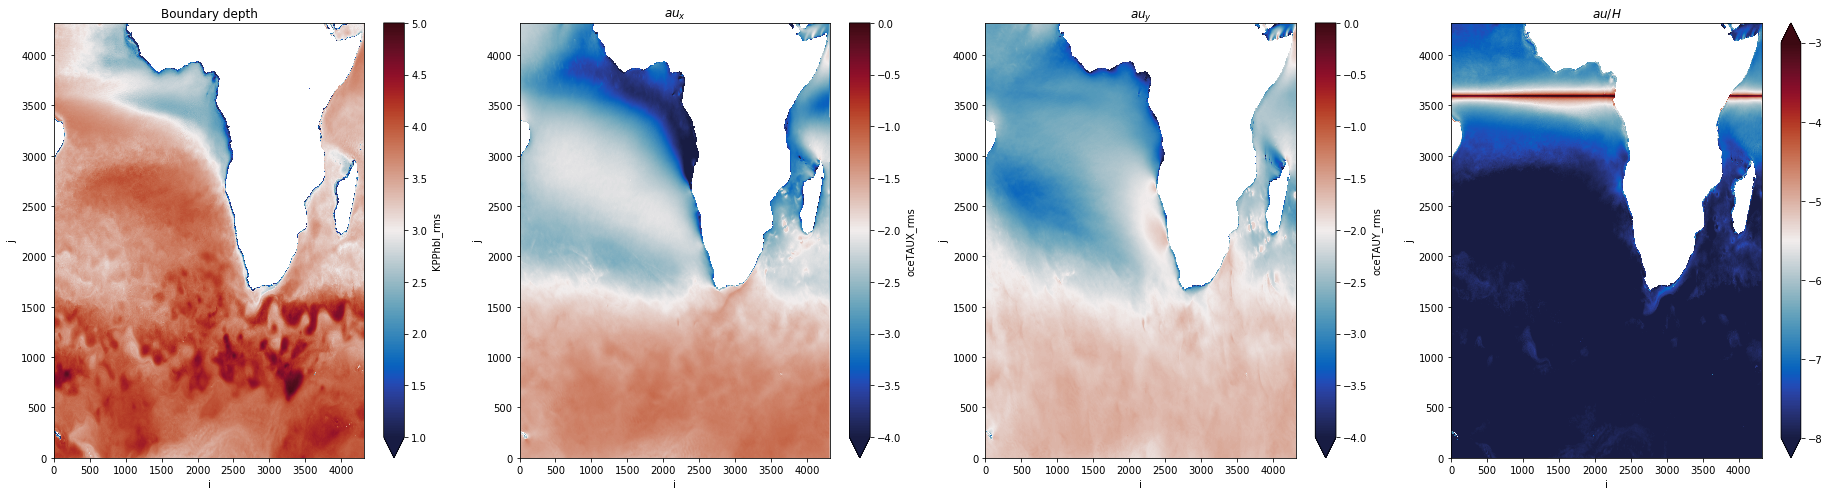

In [23]:
fig, ax = plt.subplots(figsize=(32,8))

ax = plt.subplot(141)
np.log10(ds_KPPhbl.KPPhbl_rms.isel(face=1)).plot(x='i', y='j', cmap = cm.balance, vmin=1,vmax=5)
ax.set_title('Boundary depth')

ax = plt.subplot(142)
np.log10(ds_TAUX.oceTAUX_rms.isel(face=1)).plot(x='i', y='j', cmap = cm.balance, vmin=-4,vmax=0)
ax.set_title('$\tau_x$')

ax = plt.subplot(143)
np.log10(ds_TAUY.oceTAUY_rms.isel(face=1)).plot(x='i', y='j', cmap = cm.balance, vmin=-4,vmax=0)
ax.set_title('$\tau_y$')

ax = plt.subplot(144)
np.log10( (ds_TAUX.oceTAUX_rms.isel(face=1)+ds_TAUY.oceTAUY_rms.isel(face=1))/ds_KPPhbl.KPPhbl_rms.isel(face=1)/1025/1025/(f_ij.isel(face=1)**2)/86400 ).plot(x='i', y='j', cmap = cm.balance, vmin=-8,vmax=-3)
ax.set_title('$\tau/H$')

plt.savefig('/home/c11-data/Test_aponte/xiaolong/Figures/Tau_H.png')

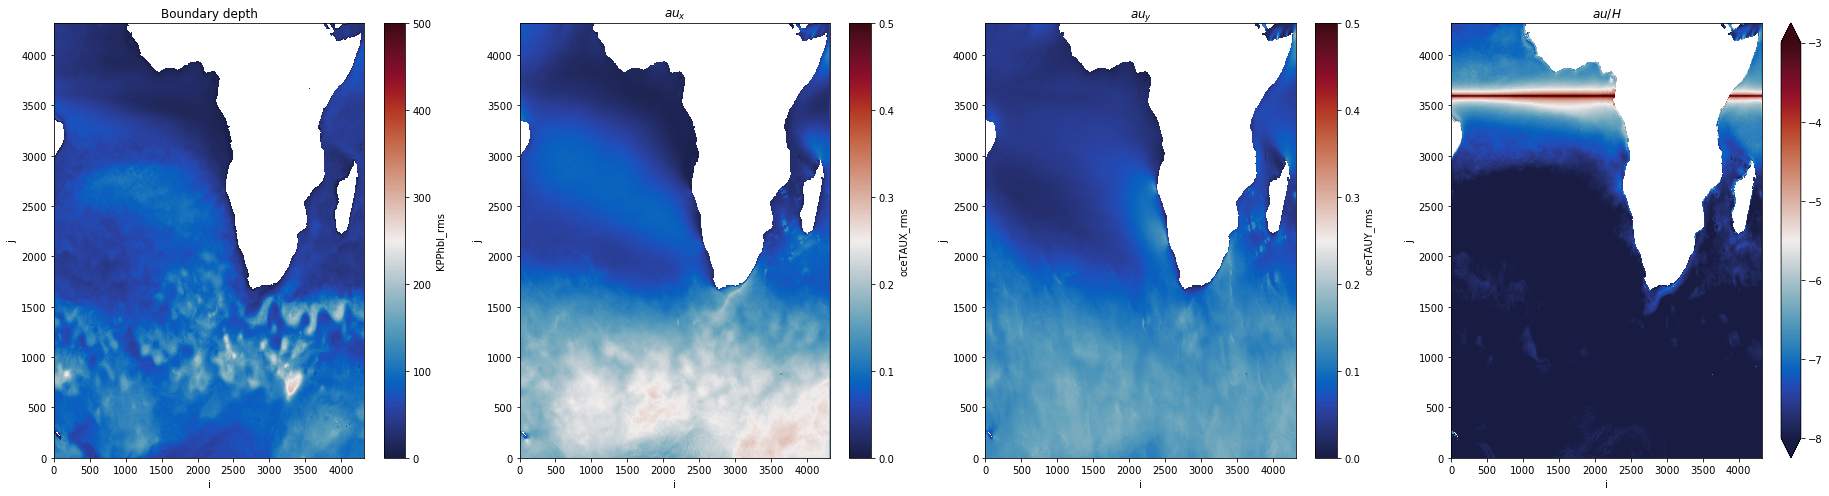

In [15]:
# linear space for RMS boundary depth, tau_x, tau_y

fig, ax = plt.subplots(figsize=(32,8))

ax = plt.subplot(141)
np.sqrt(ds_KPPhbl.KPPhbl_rms.isel(face=1)).plot(x='i', y='j', cmap = cm.balance, vmin=0,vmax=500)
ax.set_title('Boundary depth')

ax = plt.subplot(142)
np.sqrt(ds_TAUX.oceTAUX_rms.isel(face=1)).plot(x='i', y='j', cmap = cm.balance, vmin=0,vmax=0.5)
ax.set_title('$\tau_x$')

ax = plt.subplot(143)
np.sqrt(ds_TAUY.oceTAUY_rms.isel(face=1)).plot(x='i', y='j', cmap = cm.balance, vmin=0,vmax=0.5)
ax.set_title('$\tau_y$')

ax = plt.subplot(144)
np.log10( (ds_TAUX.oceTAUX_rms.isel(face=1)+ds_TAUY.oceTAUY_rms.isel(face=1))/ds_KPPhbl.KPPhbl_rms.isel(face=1)/1025/1025/(f_ij.isel(face=1)**2)/86400 ).plot(x='i', y='j', cmap = cm.balance, vmin=-8,vmax=-3)
ax.set_title('$\tau/H$')

plt.savefig('/home/c11-data/Test_aponte/xiaolong/Figures/Tau_xy_H.png')

In [16]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1